### YouTube Comment Sentiment Analysis

In [1]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from textblob import TextBlob
import matplotlib.pyplot as plt

### Load dataset

In [2]:
df = pd.read_csv("../dataset/YoutubeCommentsDataSet.csv")

In [3]:
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [4]:
df.describe()

,Comment,Sentiment
count,18364,18408
unique,17871,3
top,one of the best thing about dude is that he ne...,positive
freq,10,11432


In [5]:
df.isnull().sum()

Comment      44
Sentiment     0
dtype: int64

In [6]:
# Remove Null values
df.dropna(inplace=True)

In [7]:
df.isnull().sum()

Comment      0
Sentiment    0
dtype: int64

# Clean text 

In [8]:
# Clean text function
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\@\w+|\#","", text)
    text = re.sub(r"[^A-Za-z\s]", "", text.lower())
    return text.strip()

In [9]:
# Add sentiment polarity and subjectivity
def extract_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

In [10]:
# Apply cleaning and sentiment extraction
df["cleaned"] = df["Comment"].apply(clean_text)
df[['polarity', 'subjectivity']] = df["cleaned"].apply(lambda x: pd.Series(extract_sentiment(x)))

### TF-IDF Vectorization

In [11]:
# TF-IDF Vectorization with n-grams
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
X_tfidf = vectorizer.fit_transform(df["cleaned"])

In [12]:
# Combine TF-IDF with sentiment features
X = np.hstack((X_tfidf.toarray(), df[['polarity', 'subjectivity']].values))
y = df["Sentiment"]

In [13]:
# Balance dataset with SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)

In [14]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

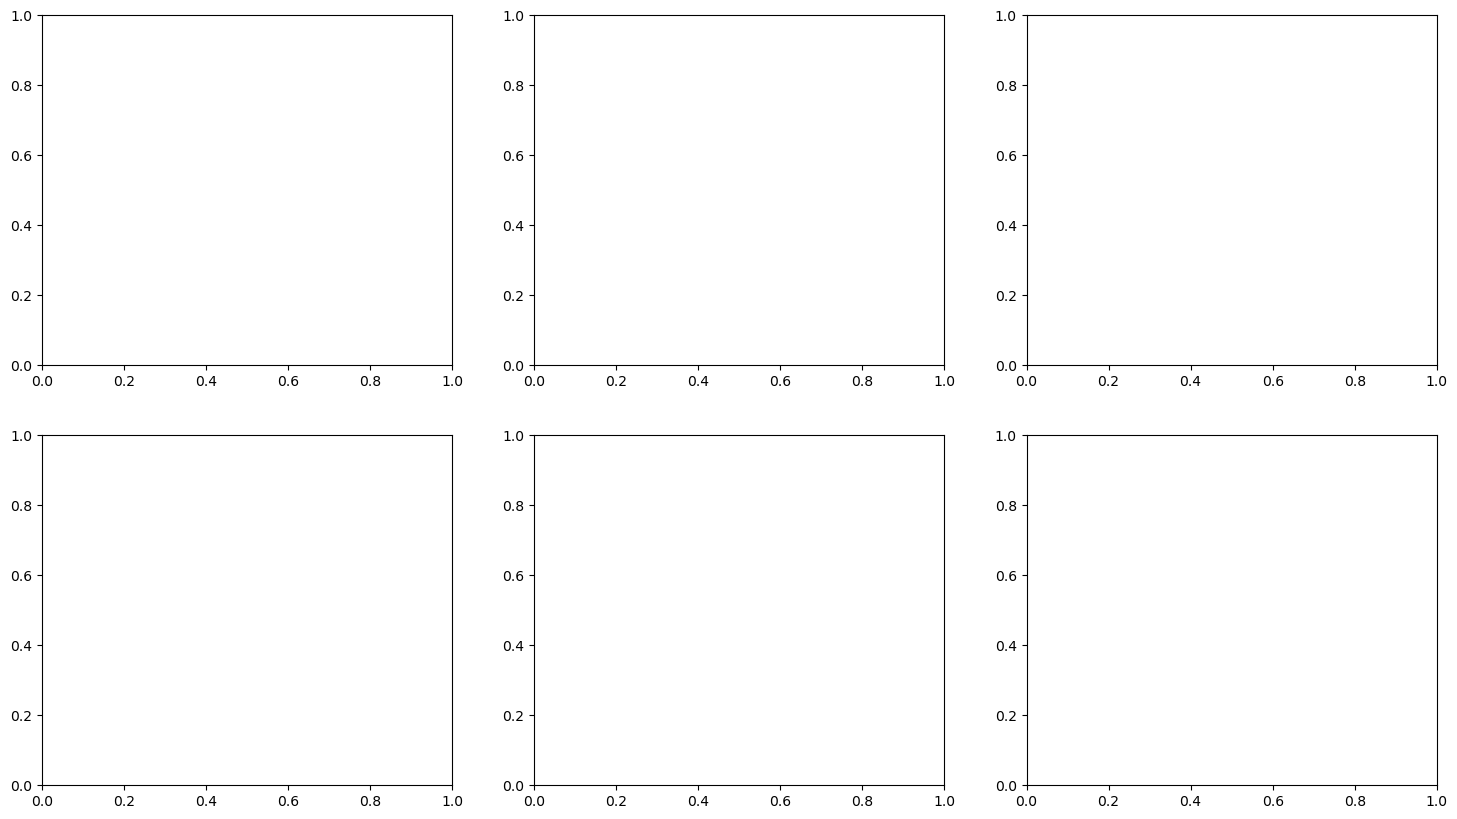

In [15]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name, ax):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
    disp.plot(ax=ax, values_format='d')
    ax.set_title(f"{model_name} Confusion Matrix")

# Initialize subplot grid for confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

# Models

## Logistic Regression

In [16]:
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train, y_train)
log_reg_preds = log_reg_model.predict(X_test)

log_reg_report = classification_report(y_test, log_reg_preds, output_dict=True)
log_reg_cm = confusion_matrix(y_test, log_reg_preds)

In [17]:
print("Logistic Regression Results:")
print("Accuracy:", log_reg_report.get("accuracy"))
print("F1-score (macro avg):", log_reg_report["macro avg"]["f1-score"])
print("Classification Report:")
print(classification_report(y_test, log_reg_preds))
print("\nConfusion Matrix:\n", log_reg_cm)

Logistic Regression Results:
Accuracy: 0.7980122771119555
F1-score (macro avg): 0.7986009347397124
Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.81      0.80      2222
     neutral       0.74      0.79      0.76      2287
    positive       0.87      0.80      0.83      2333

    accuracy                           0.80      6842
   macro avg       0.80      0.80      0.80      6842
weighted avg       0.80      0.80      0.80      6842


Confusion Matrix:
 [[1792  339   91]
 [ 290 1801  196]
 [ 176  290 1867]]


In [18]:
# Plot confusion matrix for Logistic Regression
plot_confusion_matrix(log_reg_cm, "Logistic Regression", axes[0])

## Naive Bayes

In [19]:
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train[:, :-2], y_train)
naive_bayes_preds = naive_bayes_model.predict(X_test[:, :-2])

naive_bayes_report = classification_report(y_test, naive_bayes_preds, output_dict=True)
naive_bayes_cm = confusion_matrix(y_test, naive_bayes_preds)

In [20]:
print("\nNaive Bayes Results:")
print("Accuracy:", naive_bayes_report.get("accuracy"))
print("F1-score (macro avg):", naive_bayes_report["macro avg"]["f1-score"])
print("Classification Report:")
print(classification_report(y_test, naive_bayes_preds))
print("\nConfusion Matrix:\n", naive_bayes_cm)


Naive Bayes Results:
Accuracy: 0.6886875182695118
F1-score (macro avg): 0.6762005755596179
Classification Report:
              precision    recall  f1-score   support

    negative       0.58      0.92      0.71      2222
     neutral       0.80      0.42      0.55      2287
    positive       0.81      0.73      0.77      2333

    accuracy                           0.69      6842
   macro avg       0.73      0.69      0.68      6842
weighted avg       0.73      0.69      0.68      6842


Confusion Matrix:
 [[2045   66  111]
 [1037  953  297]
 [ 445  174 1714]]


In [21]:
# Plot confusion matrix for Naive Bayes
plot_confusion_matrix(naive_bayes_cm, "Naive Bayes", axes[1])

## SVM

In [22]:
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

svm_report = classification_report(y_test, svm_preds, output_dict=True)
svm_cm = confusion_matrix(y_test, svm_preds)

In [23]:
print("\nSVM Results:")
print("Accuracy:", svm_report.get("accuracy"))
print("F1-score (macro avg):", svm_report["macro avg"]["f1-score"])
print("Classification Report:")
print(classification_report(y_test, svm_preds))
print("\nConfusion Matrix:\n", svm_cm)


SVM Results:
Accuracy: 0.8363051739257527
F1-score (macro avg): 0.8367297549010401
Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.87      0.86      2222
     neutral       0.79      0.83      0.81      2287
    positive       0.88      0.81      0.85      2333

    accuracy                           0.84      6842
   macro avg       0.84      0.84      0.84      6842
weighted avg       0.84      0.84      0.84      6842


Confusion Matrix:
 [[1940  227   55]
 [ 203 1890  194]
 [ 153  288 1892]]


In [24]:
# Plot confusion matrix for SVM
plot_confusion_matrix(svm_cm, "SVM", axes[2])

## Random Forest

In [25]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

rf_report = classification_report(y_test, rf_preds, output_dict=True)
rf_cm = confusion_matrix(y_test, rf_preds)

In [26]:
print("\nRandom Forest Results:")
print("Accuracy:", rf_report.get("accuracy"))
print("F1-score (macro avg):", rf_report["macro avg"]["f1-score"])
print("Classification Report:")
print(classification_report(y_test, rf_preds))
print("\nConfusion Matrix:\n", rf_cm)


Random Forest Results:
Accuracy: 0.8743057585501316
F1-score (macro avg): 0.8739458054065302
Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.94      0.90      2222
     neutral       0.87      0.82      0.84      2287
    positive       0.88      0.87      0.87      2333

    accuracy                           0.87      6842
   macro avg       0.87      0.87      0.87      6842
weighted avg       0.87      0.87      0.87      6842


Confusion Matrix:
 [[2085   67   70]
 [ 209 1878  200]
 [  99  215 2019]]


In [27]:
# Plot confusion matrix for Random Forest
plot_confusion_matrix(rf_cm, "Random Forest", axes[3])

In [28]:
# Adjust layout
plt.tight_layout()
plt.suptitle("Confusion Matrices for All Models", fontsize=16, y=1.03)
plt.show()

<Figure size 640x480 with 0 Axes>